In [1]:
import os
import time
import random

import sys
sys.path.append('..') # to import local FederatedEnhancedDataSynthesizer version

import matplotlib.pyplot as plt
plt.style.use('classic')

from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.lib.utils import display_bayesian_network

from DataSynthesizer.lib.utils import mutual_information

from DataSynthesizer.federated_utils.evaluation import HistogramAndHeatmapComparison, TaskUtility
from DataSynthesizer.federated_utils.partitions import partition_dataset, plot_partition
from DataSynthesizer.federated_utils.evaluation import plot_bayesian_network
from DataSynthesizer.federated_utils.client import client_fn, FedClient
from DataSynthesizer.federated_utils.server import FedServer


import numpy as np
import pandas as pd
from sklearn import preprocessing
import multiprocessing

le = preprocessing.LabelEncoder()

file_path=os.getcwd() 
traindata = os.path.join(file_path+'/data/',"adult_complete.csv")
testdata = os.path.join(file_path+'/data/',"adult_test.csv")

data=traindata
diff=0
k=2 
number_of_clients = 5
partition_scenario_fl = 'iid'
source_genes=10
genepool_size=200
# sensi='relationship'
target='income'

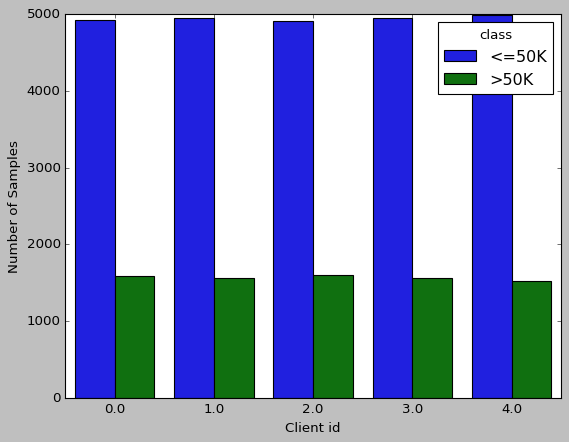

In [2]:
input_dir = f'in/federated_learning/experiment_{partition_scenario_fl}_{number_of_clients}_clients'

# Check if path for saving results exists, if not creates the corresponding folders
if not os.path.exists(input_dir):
        os.makedirs(input_dir)

output_dir = f'out/federated_correlated_attribute_mode_ga/experiment_{partition_scenario_fl}_{number_of_clients}_clients'

# Check if path for saving results exists, if not creates the corresponding folders
if not os.path.exists(output_dir):
        os.makedirs(output_dir)

synthetic_data = os.path.join(file_path, output_dir, "DSv_"+str(k)+"_syntraindata.csv")

description_file_ga = os.path.join(file_path, output_dir, "ga_corrmeta_fed.json")

# Original training data in the centralized scenario. 
input_df = pd.read_csv(data, skipinitialspace=True)
test_df = pd.read_csv(testdata, skipinitialspace=True)

# Partition the training data in different clients and generate local datasets based on the fl scenario (iid, non-iid).
clients_partition = partition_dataset(data, number_of_clients, partition_scenario_fl)
for elem in clients_partition.items(): # TODO: could be added as part of the partition_dataset funtion.
    local_partition = input_df.filter(items = elem[1], axis=0)
    local_file_client = os.path.join(file_path, input_dir, f"data_client{elem[0]}.csv")
    local_partition.to_csv(local_file_client, index=False)

# Plot distribution scenario in the federated learning scenario.
plot_partition(clients_partition, input_df[target].values)

# An attribute is categorical if its domain size is less than this threshold.
# Here modify the threshold to adapt to the domain size of "education" (which is 14 in input dataset).
threshold_value = 20

# Specify categorical attributes
categorical_attributes = {'workclass': True, 'education-num': True, 'marital-status': True, 'occupation': True, 'relationship': True,
                          'race': True, 'sex': True, 'native-country': True, 'income': True}

# Specify which attributes are candidate keys of input dataset.
candidate_keys = {}

# A parameter in Differential Privacy. It roughly means that changing a row in the input dataset will not
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = diff

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = k

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = len(input_df)

In [3]:
# Federated Learning Process 

# Initialization Process ( Each client shares with the server the min-max of numerical columns and then for categorical columns the possible categories)
# Main aim of the initialization process is to standarize the encoding of columns for each of the participants. 

# We create an instance of each client in the federated round.
clients={}
for client_id in range(number_of_clients):
    local_file_client = os.path.join(file_path, input_dir, f"data_client{client_id}.csv")
    clients[client_id] = client_fn(client_id, local_file_client, threshold_value, categorical_attributes)

# We initialize the server.
server = FedServer(number_of_clients)


In [4]:
# ----------------------   Communication for initialization and setting common encoding all attributes  -------------------------------------------------------------

# In the initialization, a random client is choosen to get the name of the attributes in the local datasets.
random.seed(0)
random_index = random.sample(list(clients.keys()),1)[0] 
all_attributes = clients[random_index].get_minimum_attributes_metadata()
server.get_attributes_metadata(all_attributes)
 
# In the first communication round the server asks all the clients for the min-max values for the numerical columns and possible categories in the categorical columns.
result_numerical_columns = []
result_categorical_columns = []
for client in clients.values(): # Simulating Communication Round (Client-Server)
    result_numerical_columns.append(client.get_min_max_numerical_attributes(server.attributes_metadata['numerical_attributes']))
    result_categorical_columns.append(client.get_values_from_categorical_attributes(server.attributes_metadata['categorical_attributes']))
server.compute_global_min_max_numeric_columns(result_numerical_columns)
server.align_categorical_columns(result_categorical_columns)

# In the next communication round, each client updates the min-max values and categories with the parameters send by the server.
for key, client in clients.items():
    client.set_global_attributes_info(server.attributes_metadata)
    client.set_distributions() 

In [5]:
# Now, the communication rounds for the federated genetic algorithm start. 
total_epochs = 400
aggregation_interval = 20

for epoch in range(total_epochs):
    best_individuals= []
    # Based on the interval
    if epoch % aggregation_interval == 0: 
        for client in clients.values():
            print(f'================================= Client {client.id} ====================================')
            fl_round = epoch // aggregation_interval
            best_individual=client.fit(aggregation_interval,fl_round,server.params_aggregation)
            best_individuals.append(best_individual) # This is done by the server
        server.aggregate_fit(fl_round,best_individuals)

================================= Client 0 ====================================
 Federated Round 0 - Epoch 1/20
(2.3620164944692443, [[10, 4, 8, 2, 1, 11, 5, 0, 3, 9, 12, 7, 6], [8, 10], [2, 4], [4, 8], [5, 0], [10, 0], [10, 4], [12, 8], [2, 1], [10, 4], [11, 10], [10, 0], [2, 4], [0, 4]])
-----

 Federated Round 0 - Epoch 2/20
(2.4083275627261815, [[10, 4, 8, 2, 1, 11, 5, 0, 3, 9, 12, 7, 6], [11, 10], [10, 4], [4, 8], [5, 0], [10, 0], [10, 4], [12, 8], [2, 1], [10, 4], [11, 10], [10, 0], [2, 4], [0, 4]])
-----

 Federated Round 0 - Epoch 3/20
(2.7304902587535014, [[0, 8, 4, 2, 11, 1, 5, 7, 3, 9, 12, 10, 6], [8, 10], [2, 4], [0, 4], [5, 0], [0, 8], [2, 4], [12, 8], [2, 5], [0, 4], [11, 7], [1, 0], [2, 4], [0, 5]])
-----

 Federated Round 0 - Epoch 4/20
(2.7363051508221203, [[0, 8, 4, 2, 11, 5, 1, 7, 3, 9, 12, 10, 6], [8, 10], [2, 4], [0, 4], [5, 0], [0, 8], [2, 4], [12, 8], [1, 5], [0, 4], [11, 7], [1, 0], [2, 4], [0, 5]])
-----

 Federated Round 0 - Epoch 5/20
(2.8634404601727357, [[0

In [6]:
# Collect final results with evaluation values and select the model which in average has the highest MI.
evaluation_results=[]
for client in clients.values():
    eval_result=client.evaluation(server.params_aggregation)
    evaluation_results.append(eval_result) 

In [7]:
# Update final BN in the clients and learn conditional probabilities in each client (sum results in the server).
all_conditional_probabilities =[]
for client in clients.values():
    client.update_final_model(server.aggregate_evaluation(evaluation_results))
    all_conditional_probabilities.append( client.describer.data_description['conditional_probabilities'])
server.aggregate_conditional_probabilities(all_conditional_probabilities)

3.303161699157407
3.303161699157407
3.303161699157407
3.303161699157407
3.303161699157407


c:\Users\DMartinez\Documents\Repositories\EnhancedDataSynthesizer\notebooks\..\DataSynthesizer\federated_utils\evaluation.py:197: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


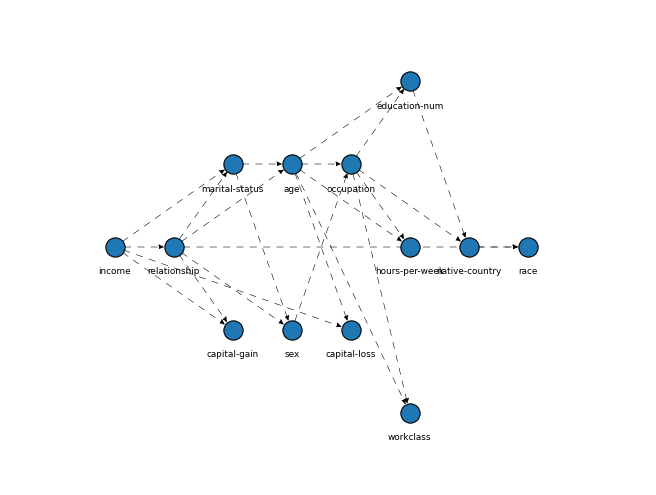

In [8]:
# To each client asign the global conditional probabilities so they have the final model
for client in clients.values():
    client.update_parameters(server.conditional_probabilities)
    
# Choose a random client to save data description
random_index = random.sample(list(clients.keys()),1)[0] 
clients[random_index].describer.save_dataset_description_to_file(description_file_ga)
plot_bayesian_network(clients[random_index].describer.bayesian_network)

In [9]:
#Data Generator:
start=time.time()
ga_generator = DataGenerator()
ga_generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file_ga)
ga_generator.save_synthetic_data(synthetic_data)

end=time.time()
gen_time=end-start
print("Runtime Data Generation:", gen_time)

# Read data for evaluation
syn_df = pd.read_csv(synthetic_data)

Runtime Data Generation: 14.697214841842651


In [10]:
output=True
if output: 
    HistogramAndHeatmapComparison(data, synthetic_data, output_dir)
    TaskUtility(input_df,syn_df,test_df,target,output_dir,'Classification')

c:\Users\DMartinez\Documents\Repositories\EnhancedDataSynthesizer\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\DMartinez\Documents\Repositories\EnhancedDataSynthesizer\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options: